# <U> Detecting Fraudulent Transactions <u>

<li>Fraud detection in credit card transaction is an important area of study which attains its importance in the increasing fraud risk posed on credit card by fraudsters to steal money from others’ accounts. </li>

<li>In the last several years, to identify fraud in credit card transaction the applications of machine learning has shown optimistic result; however, machine learning in the credit card transaction also has certain challenges. </li>

<li>There are numerous proposed machine learning algorithms that can be used to detect fraud cases; however, not every model has been proved to be the best since each technique works well with a certain data set, and fraudsters improve themselves to avoid detection by current fraud detection systems.</li>

<img src="https://www.business2community.com/wp-content/uploads/2015/11/online-fraud.jpg">

## Import Libraries

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

## Data Cleaning & Exploration

In [4]:
cred_trans = pd.read_csv('data/ibm_card_data_unlabelled.csv')
cred_trans.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?
0,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN
1,0,0,2002,9,8,13:48,$76.57,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN
2,0,0,2002,9,10,06:22,$102.18,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN
3,0,0,2002,9,12,06:21,$122.10,Swipe Transaction,4060646732831064559,La Verne,CA,91750.0,5411,Insufficient Balance
4,0,0,2002,9,23,06:46,$35.28,Swipe Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN


In [5]:
cred_trans.shape
## Dataset has 2,435,415 rows and 14 columns

(2435415, 14)

## Cleaning

In [6]:
## Let's remove the white space in the columns and replace them with underscore
cred_trans.columns = [x.replace(" ", "_").replace("?", "") for x in cred_trans.columns]
cred_trans.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use_Chip',
       'Merchant_Name', 'Merchant_City', 'Merchant_State', 'Zip', 'MCC',
       'Errors'],
      dtype='object')

###  Check Nulls

In [7]:
## Iterating through columns to find out which columns contain nulls via list comprehension
[features for features in cred_trans.columns if cred_trans[features].isnull().sum()>0]
## Three columns have nulls

['Merchant_State', 'Zip', 'Errors']

In [8]:
## Let's see how many nulls there are in the respective columns
cred_trans.isnull().sum()
## We also have missing values in Errors which essentially means that there were no errors.

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  0
Use_Chip                0
Merchant_Name           0
Merchant_City           0
Merchant_State     271897
Zip                287575
MCC                     0
Errors            2396823
dtype: int64

In [9]:
## Let's see the datatypes of each column
cred_trans.info()
## Amount will need to be changed to float to be able to make any observations with this.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2435415 entries, 0 to 2435414
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use_Chip        object 
 8   Merchant_Name   int64  
 9   Merchant_City   object 
 10  Merchant_State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors          object 
dtypes: float64(1), int64(7), object(6)
memory usage: 260.1+ MB


In [10]:
cred_trans.describe()

,User,Card,Year,Month,Day,Merchant_Name,Zip,MCC
count,2.435415e+06,2.435415e+06,2.435415e+06,2.435415e+06,2.435415e+06,2.435415e+06,2.147840e+06,2.435415e+06
mean,1.001357e+03,1.351327e+00,2.011955e+03,6.526058e+00,1.571609e+01,-4.793011e+17,5.094908e+04,5.560106e+03
std,5.694199e+02,1.406723e+00,5.106470e+00,3.472406e+00,8.794665e+00,4.762531e+18,2.939525e+04,8.787887e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.110000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.509350e+18,2.836600e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.948098e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756600e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.222877e+18,9.992800e+04,9.402000e+03


In [11]:
cred_trans.Year.sort_values().min()

1991

In [12]:
cred_trans.Year.sort_values().max()

2020

> Dataset ranges from 1991-2020

In [13]:
## Let's see how many different type of errors there are.
cred_trans['Errors'].unique()
## There are 22 different types of errors (excluding the NaNs)

array([nan, 'Insufficient Balance', 'Bad PIN', 'Technical Glitch',
       'Bad Expiration', 'Bad CVV', 'Bad Card Number',
       'Bad PIN,Insufficient Balance',
       'Bad Card Number,Bad Expiration,Technical Glitch', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch',
       'Bad Card Number,Bad Expiration', 'Bad Expiration,Bad CVV',
       'Bad Card Number,Insufficient Balance', 'Bad CVV,Technical Glitch',
       'Bad CVV,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Card Number,Bad CVV', 'Bad Expiration,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad Zipcode,Technical Glitch',
       'Bad Expiration,Insufficient Balance',
       'Bad Card Number,Bad Expiration,Insufficient Balance'],
      dtype=object)

In [14]:
cred_trans.User.value_counts()
## There are 2,000 users in this dataset. We can also see the amount of transactions each user has made.

396     8214
486     8123
332     7072
262     6751
1249    6620
        ... 
1454       2
457        2
1817       1
1793       1
221        1
Name: User, Length: 2000, dtype: int64

In [15]:
cred_trans.Card.unique()
## There are 9 different types of cards being used

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [16]:
cred_trans.Use_Chip.unique()

## There are 3 different types of transactions being done: 1) Swipe 2) Online 3) Chip
## We could probably map these numerically

array(['Swipe Transaction', 'Online Transaction', 'Chip Transaction'],
      dtype=object)

In [17]:
errs_by_year = cred_trans.groupby('Year')[['Errors']].count().sort_values('Year', ascending = True)
errs_by_year
## Less errors were made in the early 90's
## We can split data into 2 categories based on number of errors classifications:
## 1991-2004 < 1000 errors; 2005-2020 < 2000 errors (exception of 498 errors in 2020)
## Errors reached the 1000's from 2005 onwards

,Errors
Year,
1991,3
1992,2
1993,17
1994,30
1995,30
1996,46
1997,85
1998,127
1999,208


In [18]:
cred_trans['Errors'].value_counts()
## Most of the errors are due to insufficient balance

Insufficient Balance                                   24187
Bad PIN                                                 5901
Technical Glitch                                        4794
Bad Card Number                                         1272
Bad Expiration                                          1031
Bad CVV                                                 1024
Bad Zipcode                                              211
Bad PIN,Insufficient Balance                              53
Insufficient Balance,Technical Glitch                     48
Bad Card Number,Insufficient Balance                      16
Bad PIN,Technical Glitch                                  11
Bad CVV,Insufficient Balance                              10
Bad Card Number,Bad CVV                                    7
Bad Expiration,Insufficient Balance                        5
Bad Expiration,Bad CVV                                     5
Bad Card Number,Bad Expiration                             5
Bad CVV,Technical Glitch

In [19]:
cred_trans['Errors'].notnull().sum().sum()
## There are 38592 errors within the dataframe

38592

In [20]:
cred_trans.groupby('Year')[['Errors', 'Use_Chip']].value_counts()
## Errors based on year and their type of transaction

Year  Errors                        Use_Chip          
1991  Technical Glitch              Swipe Transaction     1
      Insufficient Balance          Swipe Transaction     1
      Bad Zipcode                   Swipe Transaction     1
1992  Insufficient Balance          Swipe Transaction     2
1993  Insufficient Balance          Swipe Transaction     9
                                                         ..
2020  Technical Glitch              Online Transaction    6
      Bad PIN,Insufficient Balance  Chip Transaction      4
      Bad Zipcode                   Swipe Transaction     1
                                    Chip Transaction      1
      Bad PIN,Technical Glitch      Chip Transaction      1
Length: 357, dtype: int64

In [21]:
cred_trans.groupby('Use_Chip')[['Errors']].value_counts()
## Errors based on type of transactions. We see that most of the errors come from chip transaction

Use_Chip            Errors                                             
Chip Transaction    Insufficient Balance                                    6260
                    Bad PIN                                                 1720
                    Technical Glitch                                        1230
                    Bad Zipcode                                               52
                    Bad PIN,Insufficient Balance                              15
                    Insufficient Balance,Technical Glitch                      8
                    Bad PIN,Technical Glitch                                   7
                    Bad Zipcode,Insufficient Balance                           2
                    Bad Zipcode,Technical Glitch                               1
Online Transaction  Insufficient Balance                                    2033
                    Bad Card Number                                         1272
                    Bad Expiration   

## FEATURE ENGINEERING
> ### Filling missing values using fillna
> ### Changing the Name of the 'Amount' column
> ### Creating bins for certain columns
> ### Changing the Time column to a 24hr format

In [22]:
def feature_eng(df):
    """ Function to fill nulls and label encode the following columns: 'Errors', 'Use_Chip', 'Merchant_City', 'Merchant_State' """
    cols_to_encode = ['Errors', 'Use_Chip', 'Merchant_City', 'Merchant_State']
    trans = df.copy()
    labelencoder = LabelEncoder()

    # label encoding categrical column values
    for col in cols_to_encode:
        trans[col].fillna("0", inplace = True)
        trans[col + '_Encoded'] = labelencoder.fit_transform(trans[col]) ## Label encoding all stated columns so that later our algorithm can understand the numerical data

    ## Removing the Dollar sign from the Amount column in order to change object to float.
    trans['Amount'] = trans['Amount'].replace({'\$' : ''}, regex=True).astype(float)

    trans.drop(cols_to_encode, axis=1, inplace=True) ## Dropping the original columns, since we have now created new encoded columns

    trans['Zip'].fillna(0, inplace = True) ## Filling all null values in the zip column with 0
    trans['Time'] = trans['Time'].str[:2].astype('int')
    trans['Suspected_Fraud'] = np.where(trans['Errors_Encoded']!= 0, 1, 0) ## Classifying suspected fraud with a 1 (i.e. the rows which have erroneous transactions, otherwise a 0.

    return trans

cred_trans = feature_eng(cred_trans)

In [23]:
cred_trans.head(100)

,User,Card,Year,Month,Day,Time,Amount,Merchant_Name,Zip,MCC,Errors_Encoded,Use_Chip_Encoded,Merchant_City_Encoded,Merchant_State_Encoded,Suspected_Fraud
0,0,0,2002,9,2,17,128.95,3414527459579106770,91754.0,5651,0,2,6444,26,0
1,0,0,2002,9,8,13,76.57,-727612092139916043,91754.0,5411,0,2,6444,26,0
2,0,0,2002,9,10,6,102.18,3527213246127876953,91750.0,5300,0,2,5150,26,0
3,0,0,2002,9,12,6,122.10,4060646732831064559,91750.0,5411,20,2,5150,26,1
4,0,0,2002,9,23,6,35.28,-34551508091458520,91750.0,5912,0,2,5150,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,2005,3,27,20,69.66,2874505148349436413,78753.0,5812,0,2,403,178,0
96,0,0,2005,4,5,6,39.80,4060646732831064559,91750.0,5411,0,2,5150,26,0
97,0,0,2005,4,18,6,118.49,-34551508091458520,91750.0,5912,0,2,5150,26,0
98,0,0,2005,4,25,10,41.07,4055257078481058705,91750.0,7538,0,2,5150,26,0


In [24]:
cred_trans.isnull().sum()

User                      0
Card                      0
Year                      0
Month                     0
Day                       0
Time                      0
Amount                    0
Merchant_Name             0
Zip                       0
MCC                       0
Errors_Encoded            0
Use_Chip_Encoded          0
Merchant_City_Encoded     0
Merchant_State_Encoded    0
Suspected_Fraud           0
dtype: int64

In [25]:
cred_trans.dtypes

User                        int64
Card                        int64
Year                        int64
Month                       int64
Day                         int64
Time                        int32
Amount                    float64
Merchant_Name               int64
Zip                       float64
MCC                         int64
Errors_Encoded              int32
Use_Chip_Encoded            int32
Merchant_City_Encoded       int32
Merchant_State_Encoded      int32
Suspected_Fraud             int32
dtype: object

## Visualisation

In [26]:
cred_trans.corr()

,User,Card,Year,Month,Day,Time,Amount,Merchant_Name,Zip,MCC,Errors_Encoded,Use_Chip_Encoded,Merchant_City_Encoded,Merchant_State_Encoded,Suspected_Fraud
User,1.000000,0.010463,0.001466,0.000677,0.001186,-0.010878,-0.011649,0.016337,-0.020087,0.011153,-0.000294,0.002714,-0.032266,0.029183,-0.000720
Card,0.010463,1.000000,-0.070329,0.000821,0.001018,-0.007951,-0.002706,0.020381,0.037735,0.012079,-0.000621,0.038578,0.010524,0.000534,-0.000800
Year,0.001466,-0.070329,1.000000,-0.055510,-0.000821,-0.006575,-0.011100,-0.002017,-0.024191,-0.000773,-0.001964,-0.619498,-0.007097,-0.021746,-0.000812
Month,0.000677,0.000821,-0.055510,1.000000,0.014052,0.000101,-0.000679,0.000024,0.000843,0.000880,-0.000412,0.032035,0.000398,0.002329,-0.000394
Day,0.001186,0.001018,-0.000821,0.014052,1.000000,-0.000061,0.000099,-0.000902,-0.000472,0.000805,0.000491,0.001292,0.000041,0.001243,0.000435
Time,-0.010878,-0.007951,-0.006575,0.000101,-0.000061,1.000000,0.052221,-0.005819,0.000070,0.029028,0.004494,0.002606,-0.012111,0.008975,0.004114
Amount,-0.011649,-0.002706,-0.011100,-0.000679,0.000099,0.052221,1.000000,-0.014479,-0.038905,-0.036965,0.027061,-0.002317,0.025658,-0.027246,0.026739
Merchant_Name,0.016337,0.020381,-0.002017,0.000024,-0.000902,-0.005819,-0.014479,1.000000,0.038147,0.074805,-0.004883,0.014583,-0.010393,0.048402,-0.006256
Zip,-0.020087,0.037735,-0.024191,0.000843,-0.000472,0.000070,-0.038905,0.038147,1.000000,0.105738,0.002644,0.079724,-0.043656,0.111918,-0.008247
MCC,0.011153,0.012079,-0.000773,0.000880,0.000805,0.029028,-0.036965,0.074805,0.105738,1.000000,-0.006157,0.032347,-0.053691,0.140687,-0.011014


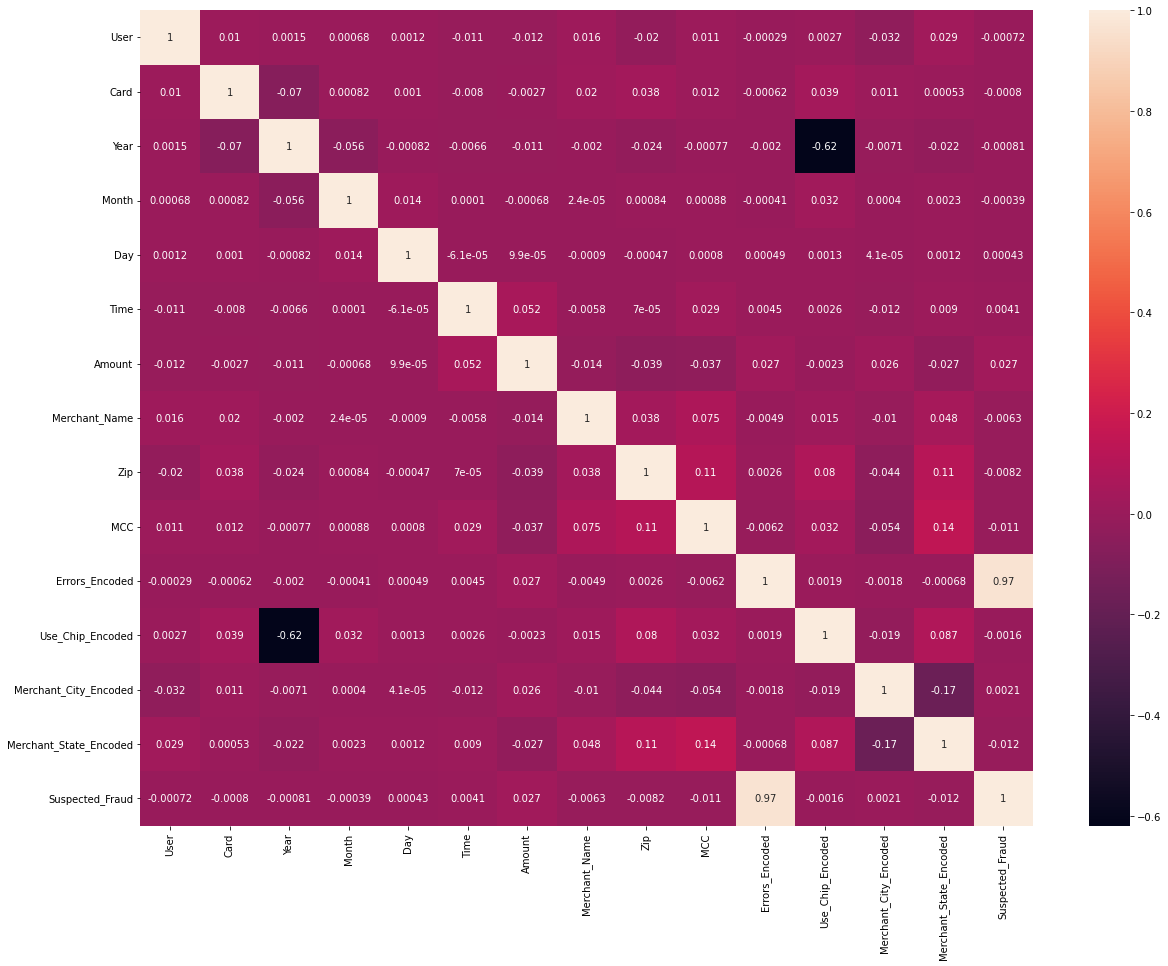

In [27]:
plt.figure(figsize=(20,15))
sns.heatmap(cred_trans.corr(), annot=True, cmap='rocket')
plt.show()

> ### In the above heatmap the only strong correlation we can see within our dataset is between type of transaction (Use_chip) and Year with a correlation coefficient of -0.62. However, the rest of the dataset is not giving us any strong correlations to indicate any suspicious fraudulent causes. This is to be expected as the dataset is large and unlabelled dataset with no target.

## Sub-Sampling Data
> Let's work with a dataframe that contains just the errors (containing 38592 rows) and concatenate this with an equal number
> of rows with the non-erroneous data so that we're working with a fair sample size.

In [28]:
def subsample_data(df,n=38592,random_state=123):
    """
    get an undersampled version of dataset containing erroneous and non_erroneous in 1:1 ratio 
    """
    df_errors = df.loc[cred_trans['Suspected_Fraud'] != 0].copy() ## Dataframe containing 'Suspected Fraud' i.e. Erroneous data
    non_errors = df.loc[cred_trans['Suspected_Fraud'] == 0].copy() ## Dataframe containing 'Suspected Fraud' i.e. Non-Erroneous data
    df_non_errors = non_errors.sample(n=n, random_state=random_state)
    X_concat = pd.concat([df_errors, df_non_errors])

    print(X_concat.shape)
    return X_concat

In [29]:
X = subsample_data(cred_trans)
X.head()

(77184, 15)


,User,Card,Year,Month,Day,Time,Amount,Merchant_Name,Zip,MCC,Errors_Encoded,Use_Chip_Encoded,Merchant_City_Encoded,Merchant_State_Encoded,Suspected_Fraud
3,0,0,2002,9,12,6,122.10,4060646732831064559,91750.0,5411,20,2,5150,26,1
51,0,0,2003,10,1,6,121.12,1913477460590765860,91750.0,5300,20,2,5150,26,1
86,0,0,2005,2,10,19,15.85,5817218446178736267,91750.0,5912,14,2,5150,26,1
100,0,0,2005,5,13,13,61.40,2027553650310142703,84084.0,5541,22,2,10619,187,1
119,0,0,2005,11,27,6,118.52,-245178307025547046,91750.0,5311,20,2,5150,26,1


In [30]:
## Let's drop the 'Suspected Fraud Column' to exclude this out from the modelling. Let's create a copy of the X dataframe
X_copy = X.drop(columns=['Suspected_Fraud']).copy()
X_copy.head()

,User,Card,Year,Month,Day,Time,Amount,Merchant_Name,Zip,MCC,Errors_Encoded,Use_Chip_Encoded,Merchant_City_Encoded,Merchant_State_Encoded
3,0,0,2002,9,12,6,122.10,4060646732831064559,91750.0,5411,20,2,5150,26
51,0,0,2003,10,1,6,121.12,1913477460590765860,91750.0,5300,20,2,5150,26
86,0,0,2005,2,10,19,15.85,5817218446178736267,91750.0,5912,14,2,5150,26
100,0,0,2005,5,13,13,61.40,2027553650310142703,84084.0,5541,22,2,10619,187
119,0,0,2005,11,27,6,118.52,-245178307025547046,91750.0,5311,20,2,5150,26


<img src="https://iknowfirst.com/wp-content/uploads/2018/07/Screen-Shot-2018-07-05-at-4.53.57-PM-768x286.png">

## KMEANS Elbow Method Joint & Silhouette Coefficient

In [31]:
def kmeans_modelling(X,scaling=False):
    """Creating a function to find the best K value in terms of both scaled and unscaled data"""
    k_range = range(2, 10)
    scores = []
    inertia = []
    if scaling == True:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        #  convert numpy array to Dataframe
        X = pd.DataFrame(X_scaled,index=X.index,columns=X.columns)

    for k in k_range:
            km = KMeans(n_clusters=k, random_state=124)
            km.fit(X)
            scores.append(metrics.silhouette_score(X, km.labels_))
            inertia.append(km.inertia_)
    return inertia, scores

In [32]:
unscaled_inertia, unscaled_sc = kmeans_modelling(X_copy, scaling=False)

In [33]:
print(unscaled_inertia)

[4.3513740260850564e+41, 1.9089722719232895e+41, 1.1507716552370326e+41, 7.506873235095105e+40, 4.963596340646879e+40, 3.7800909796834057e+40, 2.7722013574664353e+40, 1.9688789605025187e+40]


In [34]:
print(unscaled_sc)

[0.6357746106512856, 0.6227439118630859, 0.6024631280177534, 0.5911601793303307, 0.5987706491097674, 0.5957947430935833, 0.6173794691418802, 0.6333421605071572]


In [35]:
k_range = range(2, 10)

In [36]:
def plot_cluster_subplots(df,n_clusters,main_title='Cluster Plot',):

    """
    function to allow us to play around with different feature columns and plot different visualisations in 4 different plots (as seen below)

    Columns with corresponding feature number
    'User' = 0, 'Card' = 1, 'Year' = 2, 'Month' = 3, 'Day' = 4,
    'Time' = 5, 'Amount' = 6, 'Merchant_Name' = 7, 'Zip' = 8,
    'MCC' = 9, 'Errors_Encoded' = 10, 'Use_Chip_Encoded' = 11,
    'Merchant_City_Encoded' = 12, 'Merchant_State_Encoded' = 13
    """

    colours = ['#3CCF4E', '#1B2430', '#D61C4E', '#3330E4', '#EF5B0C', '#EAE509']
    fig, axs = plt.subplots(1, 4, figsize=(15, 8))
    fig.suptitle(main_title)


    for i in range(0,n_clusters): ## iterating through n clusters

        filtered_df = df[df['pred_labels'] == i]
        filtered_df = filtered_df.to_numpy()

        #Plotting the results
        plt.subplot(1, 4,1)
        plt.scatter(filtered_df[:,1] , filtered_df[:,10] , c = colours[i])
        plt.title('Card Versus Errors')

        plt.subplot(1, 4,2)
        plt.scatter(filtered_df[:,5] , filtered_df[:,6] , c = colours[i])
        plt.title('Time Versus Amount')

        plt.subplot(1, 4,3)
        plt.scatter(filtered_df[:,2] , filtered_df[:,13] , c = colours[i])
        plt.title('Year Versus Merchant State')

        plt.subplot(1, 4,4)
        plt.scatter(filtered_df[:,0] , filtered_df[:,10] , c = colours[i])
        plt.title('User Versus Errors')
    plt.show()


def plot_cluster_evaluation(inertia, sc_score,k_range,inertia_title, sc_title):
    """Function to evaluate and visualise the inertia score (elbow method) as well as the silhouette coefficient"""

    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    plt.subplot(1, 2,1)
    plt.plot(k_range, inertia,color="#EF5B0C",marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('inertia')
    plt.title(inertia_title)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range, sc_score,color="#FA2FB5",marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.title(sc_title)
    plt.grid(True)



    plt.show()


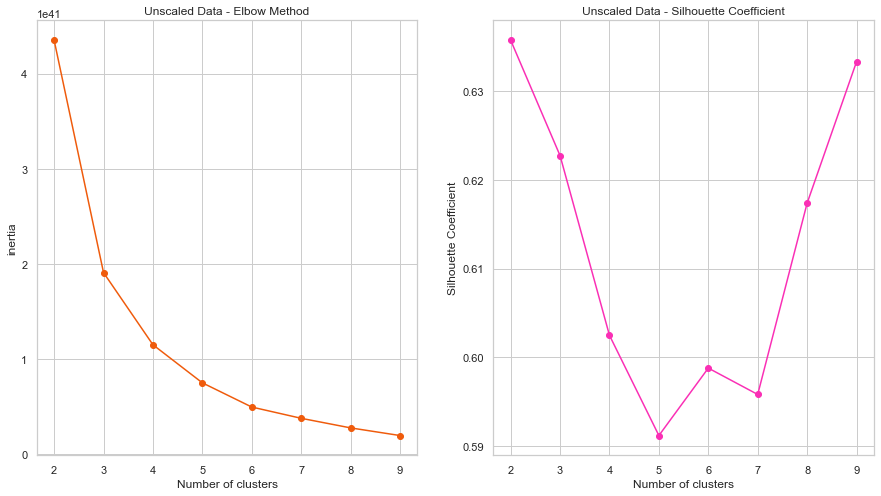

In [37]:
plot_cluster_evaluation(unscaled_inertia,unscaled_sc,k_range, "Unscaled Data - Elbow Method", "Unscaled Data - Silhouette Coefficient", )

> ### From the graph above with unscaled data, we were not able to draw an evaluation of an optimum number of clusters since we were only ranging through a K value from 2-10. The graph above detects an increase after a K of 9, but due to the computational power required and time taken to run this function, we didn't get to explore a higher K value. (for example K=10 could have produced a better silhouette coefficient)

## KMeans Cluster Plot

<u>Unscaled Data KMeans Clustering</u>

In [38]:
model = KMeans(n_clusters=5)

# Fit model to samples
model.fit(X_copy)

pred_labels = model.labels_
X_copy['pred_labels']  =pred_labels

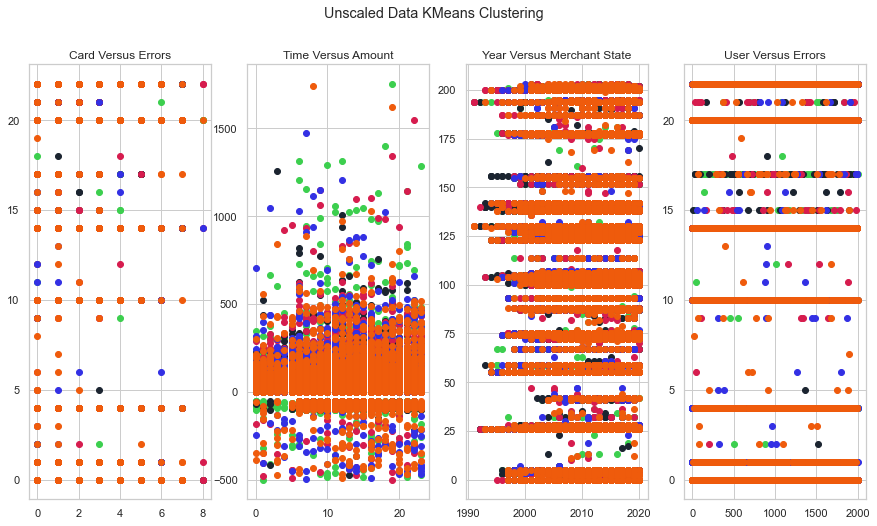

In [39]:
plot_cluster_subplots(X_copy,n_clusters=5,main_title='Unscaled Data KMeans Clustering')

<u>Scaled Data KMeans Clustering</u>

In [40]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#  convert numpy array to Dataframe
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns=X.columns)

In [41]:
scaled_inertia, scaled_sc = kmeans_modelling(X_copy, scaling=True)

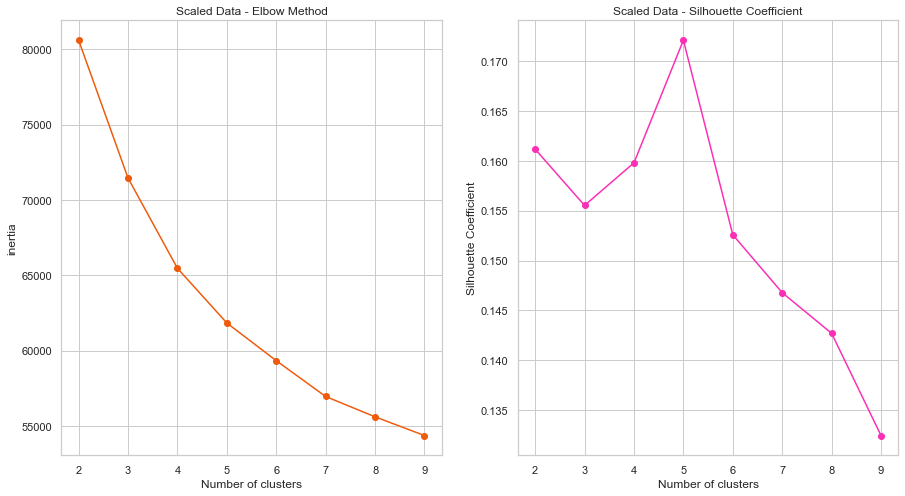

In [42]:
plot_cluster_evaluation(scaled_inertia,scaled_sc,k_range, "Scaled Data - Elbow Method", "Scaled Data - Silhouette Coefficient")

> ### From the graphs above with scaled data, the K value points to 5

> ### From the above we can conclude that scaling the data gives us a better result than unscaled data, because the range of values within the Merchant Name is quite large and hence this could be the cause for the silhouette coefficient score to fluctuate how it did in a W shape - however, this is purely based on assumption.
> ### We can also see that by looking at the scaled data, the elbow method points to an ideal number of clusters being 5 which is backed by the silhouette coefficient.


### Scaled Cluster Plot

In [1]:

model = KMeans(n_clusters=5)

# Fit model to samples
model.fit(X_scaled)

pred_labels = model.labels_
X_scaled['pred_labels']  =pred_labels
plot_cluster_subplots(X_copy,n_clusters=5,main_title='Scaled Data KMeans Clustering')


NameError: name 'KMeans' is not defined

### PCA

In [67]:
## With PCA, we use standard scaling
X_copy.drop(columns=['pred_labels'])
X_std=pd.DataFrame(StandardScaler().fit_transform(X_copy),index=X_copy.index,columns=X_copy.columns)
X_std

,User,Card,Year,Month,Day,Time,Amount,Merchant_Name,Zip,MCC,Errors_Encoded,Use_Chip_Encoded,Merchant_City_Encoded,Merchant_State_Encoded,pred_labels
3,-1.752994,-0.957140,-1.944223,0.714457,-0.421157,-1.274202,0.962603,0.994219,1.484314,-0.126723,1.144775,0.740965,-0.161241,-1.006624,-0.712751
51,-1.752994,-0.957140,-1.748905,1.002619,-1.669944,-1.274202,0.949173,0.536395,1.484314,-0.254109,1.144775,0.740965,-0.161241,-1.006624,-0.712751
86,-1.752994,-0.957140,-1.358269,-1.302675,-0.648210,1.276281,-0.493461,1.368759,1.484314,0.448233,0.520629,0.740965,-0.161241,-1.006624,0.642432
100,-1.752994,-0.957140,-1.358269,-0.438190,-0.307631,0.099135,0.130762,0.560718,1.247197,0.022467,1.352823,0.740965,1.662819,1.545066,-0.712751
119,-1.752994,-0.957140,-1.358269,1.290781,1.281734,-1.274202,0.913542,0.076121,1.484314,-0.241485,1.144775,0.740965,-0.161241,-1.006624,-1.390342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483412,-1.032932,-0.957140,-0.772314,-1.014514,-1.102314,0.687708,-0.449060,1.135428,-1.079146,-0.126723,-0.935712,0.740965,1.206220,0.594126,0.642432
1680082,0.643710,-0.957140,-0.576996,1.578942,1.281734,-1.078011,-0.571027,-0.463015,-0.183975,2.857080,-0.935712,0.740965,0.293357,1.386576,-1.390342
2112367,1.270917,1.885635,-1.553587,-0.150028,0.600578,0.099135,-0.614057,-1.444250,-0.696809,0.333471,-0.935712,0.740965,0.632887,0.182051,-0.035160
1125186,-0.111392,1.174941,1.376185,0.714457,-1.102314,-1.470393,-0.634340,0.017280,-1.353596,0.336914,-0.935712,-0.427694,0.502812,-1.418698,-1.390342


In [68]:
pca = PCA()
principalcomponents = pca.fit_transform(X_std)

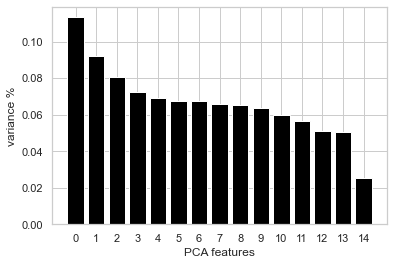

In [69]:
features = range(pca.n_components_)
plt.figure()
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()
## Features with the highest are 0, 1 and 2 which correspond to User, Card and Year respectively

> ### From the above graph we can clearly see that the first three feature components show the highest variance.

In [46]:
PCA_components = pd.DataFrame(principalcomponents)
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.993365,-0.217339,1.844025,-1.223359,1.439991,0.042869,0.313903,-1.970007,-0.737407,0.180980,0.075003,-0.266217,1.523699,-0.279286,0.869663
1,1.801616,-0.319161,1.788603,-0.951360,1.504811,-0.128293,-0.407250,-2.808809,-0.091118,0.159833,-0.004991,-0.195970,1.363085,-0.498946,0.721983
2,1.343668,-0.028167,0.445108,-0.473685,0.953140,-2.385899,-0.684854,-0.206685,-1.216826,-0.058560,-0.903760,-1.083780,1.621459,0.509701,0.514849
3,2.045409,0.449976,1.521573,-0.571623,1.702284,-1.099369,-0.027876,-0.987985,-1.209461,-0.710761,-0.459770,-0.210621,-1.451670,0.597906,0.646037
4,0.924892,-1.448719,0.849709,0.275121,1.943981,0.494182,1.927180,-1.168710,-0.707248,-0.130948,0.546766,-0.290019,1.959636,1.102740,0.438540


## KMeans modelling with PCA incorporated (i.e. 3 features)

In [47]:
ks = range(2, 10)
PCA_inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3]) ## Using 3 feature components

    # Append the inertia to the list of inertias
    PCA_inertias.append(model.inertia_)

In [48]:
def pca_cluster(PCA_inertias, scaled_inertia, PCA_Inertia_title, NON_PCA_Inertia_title):
    """"Creating a function to show both the PCA inertia in comparison to the NON PCA Intertia"""

    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    plt.subplot(1, 2,1)
    plt.plot(ks, PCA_inertias, color="#EF5B0C",marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('inertia')
    plt.title(PCA_Inertia_title)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(ks, scaled_inertia,color="#FA2FB5",marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('inertia')
    plt.title(NON_PCA_Inertia_title)
    plt.grid(True)



    plt.show()

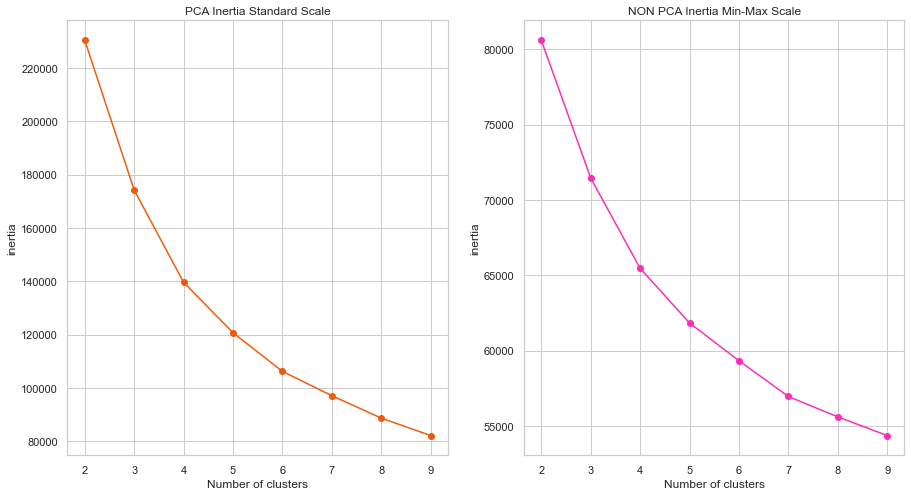

In [49]:
pca_cluster(PCA_inertias, scaled_inertia, 'PCA Inertia Standard Scale', 'NON PCA Inertia Min-Max Scale')

## Hierarchical Clustering

,User,Card,Year,Month,Day,Time,Amount,Merchant_Name,Zip,MCC,Errors_Encoded,Use_Chip_Encoded,Merchant_City_Encoded,Merchant_State_Encoded,pred_labels
3,0,0,2002,9,12,6,122.10,4060646732831064559,91750.0,5411,20,2,5150,26,1
51,0,0,2003,10,1,6,121.12,1913477460590765860,91750.0,5300,20,2,5150,26,1
86,0,0,2005,2,10,19,15.85,5817218446178736267,91750.0,5912,14,2,5150,26,3
100,0,0,2005,5,13,13,61.40,2027553650310142703,84084.0,5541,22,2,10619,187,1
119,0,0,2005,11,27,6,118.52,-245178307025547046,91750.0,5311,20,2,5150,26,0


In [51]:
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X_copy)
# x = X_scaled
# y = []
#
# # data = list(zip(x, y))
#
# hierarchical_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean')
# labels = hierarchical_cluster.fit_predict(X_scaled)
# print(labels)
# plt.scatter(x, y, c=labels)
# plt.show()

> ### If we run the above code block we get the following error message:
> ### MemoryError: Unable to allocate 22.2 GiB for an array with shape (2978646336,) and data type float64
>
> ### We did further research about this and discovered that the problem with Hierarchical clustering is:
>
> ### Space complexity: The space required for the Hierarchical clustering Technique is very high when the number of data points are high as we need to store the similarity matrix in the RAM. The space complexity is the order of the square of n. Space complexity = O(n²) where n is the number of data points.
> ### Hence we will use DBSCAN and see what results this will produce

## DBSCAN

<img src="https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png">

In [71]:
scaler = MinMaxScaler()
X_copy = X.drop(columns=['Suspected_Fraud']).copy()

X_scaled = scaler.fit_transform(X_copy)

db = DBSCAN(eps=0.5, min_samples=6, n_jobs=-1).fit(X_scaled) ## We played around with tweaking the epsilon value and minimum sample size.

# Get the cluster labels (aka numbers)
pred_labels = db.labels_

# Count the total number of clusters
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

In [72]:
# Print model results
print(f'Estimated number of clusters: {n_clusters}')

Estimated number of clusters: 5


<li> After having played around with the eps and min samples we achieved 5 clusters and we thought we would explore this further since our KMeans produced 5 clusters as an ideal K value.

In [54]:
# Print model results
print(f'Silhouette Coefficient: {metrics.silhouette_score(X_scaled, pred_labels):0.3f}')

Silhouette Coefficient: 0.190


In [55]:
print(set(pred_labels)) ## Printing the unique predicted labels

{0, 1, 2, 3, 4, -1}


## Visualize DBSCAN Plot

In [73]:
## Creating a copy dataframe of the scaled data and adding anew column called predicted labels
X_sc_copy = X_scaled.copy()
X_sc_copy = pd.DataFrame(X_sc_copy)
X_sc_copy['pred_labels'] = pred_labels

In [57]:
## Colours used for plotting the graph:
## #3CCF4E = Green
## #D61C4E = Pink
## #3330E4 = Dark Blue
## #EF5B0C = Orange
## #EAE509 = Yellow
## #1B2430 = Dark Grey

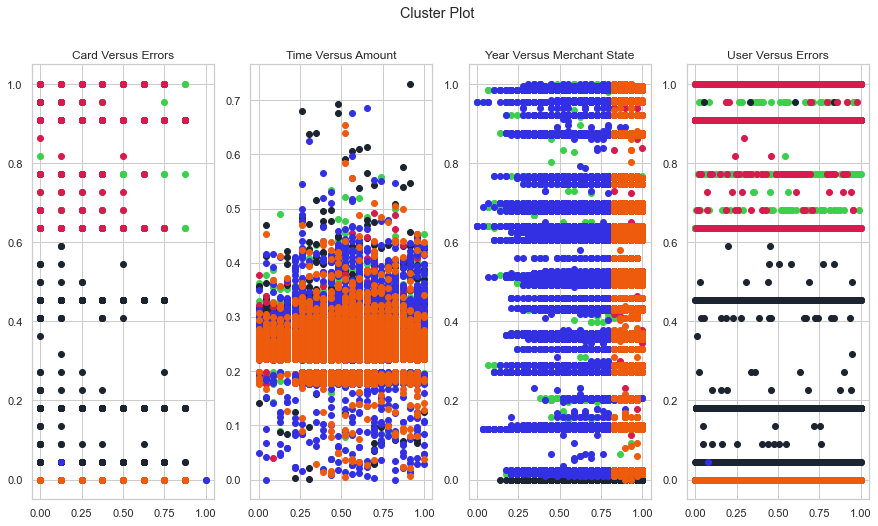

In [58]:
plot_cluster_subplots(X_sc_copy,n_clusters=5,main_title='Cluster Plot')

In [59]:
X_temp = pd.DataFrame(X_scaled,index=X_copy.index,columns=X_copy.columns)
list(X_temp.columns)
for i,col_name in enumerate(list(X_temp.columns)):
    print(i,col_name)

0 User
1 Card
2 Year
3 Month
4 Day
5 Time
6 Amount
7 Merchant_Name
8 Zip
9 MCC
10 Errors_Encoded
11 Use_Chip_Encoded
12 Merchant_City_Encoded
13 Merchant_State_Encoded


> ## Test data

In [60]:
X_new = subsample_data(cred_trans,n=50000,random_state=25)
scaler = MinMaxScaler()
X_scaled_new_sample = scaler.fit_transform(X_new)

(88592, 15)


In [75]:
def cluster_review(X,y,method=None):
    """
    Cluster Review
    """

    colours=[plt.cm.Set1(c) for c  in y]
    
    if method is None:
        fig,axs=plt.subplots(1,2)
        axs[0].scatter(X[:,0],X[:,1])
        axs[1].scatter(X[:,0],X[:,1],color=colours)
    else:

        try:
            labels=method.fit_predict(X)
            pred_colours=[]
            for n in (labels):
                if n==-1:
                    pred_colours.append(plt.cm.gray(0))
                else:
                    pred_colours.append(plt.cm.Set1(n))
            fig,axs=plt.subplots(1,3)
            axs[0].scatter(X[:,0],X[:,1])
            axs[1].scatter(X[:,0],X[:,1],color=pred_colours)
            axs[2].scatter(X[:,0],X[:,1],color=colours)
        except Exception as e:
            print(f'please use a valid clustering technique (error{e})')

    plt.show()

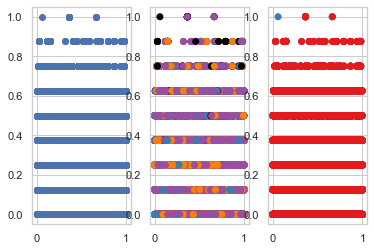

In [76]:
db1 = DBSCAN(eps=0.5, min_samples=6, n_jobs=-1)
cluster_review(X_scaled,X['Suspected_Fraud'],method=db1)

Testing against a different sample of Data
(We created a new sample data set with 88592 rows of data

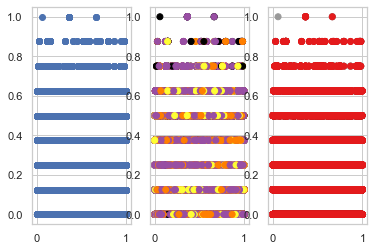

In [77]:
db2 = DBSCAN(eps=0.5, min_samples=6, n_jobs=-1)

cluster_review(X_scaled_new_sample,X_new['Errors_Encoded'],method=db2)